# 🎉 Out-of-Distribution (OOD) with PCA in Image Processing

The goal of this notebook is to understand the depths of using Principal Component Analysis in order to perform OOD tasks in the domain of image processing.

## 📝 Plan of action

### ♻️ Preprocessing phase

In order to achieve our goal, we need to understand how the dataset is structured.

For this notebook, we are going to use the CBIR 15 dataset, that contains images of different places, such as an office, a bedroom, a mountain, etc. Note that there are some places that are similar one to another, i.e. a bedroom and a living room.

Thus, in order to extract the features of the images we have to preprocess those images:

- Get the images that are located in data/CBIR_15-scene and fit them to a dataframe using Pandas
  - Locate the "Labels.txt" file: it shows where the indexes of the images from each category starts
- Create the dataset with this information with two columns: the path to the image and its category
- Transform all of the images in the same size (in this case, we are going with 256x256)
  
Now, in order to extract the features, it's necessary to divide the reshaped images into patches of 32x32 pixels. This is good to perform processing tasks to avoid waiting long periods of time.

After all the preprocess, we should separate the images into two different foldes: one contains the patches of the training images that is going to give us their principal components and dimensions, and the other is the patches of the test images, that is going to be tested to fit into those dimensions and we'll get an OOD score afterwards.

### 🏋🏽‍♂️ Training phase

With the images that are stored inside the "patches_train" folder, the first thing we are going to do is _normalize_ all of the images to find the correct maximum covariance and transforming all the variables into the same scale.

Next, we should then apply the PCA with all the components. As we have patches of 32x32, we'll be having 1024 features, hence components. Then we plot a graph to see how many components truly contributes for the most variance of the data - and give us more information about it. We're going to take the threshold of 95% of variance in this notebook.

After getting the PCA with components that describe 95% of the variance, it's time to test our images and see how far of the residual space their data can be found.

### ⚗️ Test phase and results

In this phase, we take the test images and normalize then with the same scale of each PCA. This is important to maintain consistency throughout the final results and measure the norms in the new dimension properly.

After that, we calculate the norm of the projection of the given data into the orthogonal space of the principal component and divide it by the norm of the data in relation to the origin. This is the OOD score.

We calculate the mean of the score for each category and get the minimal one. The current environment is the smallest.


--------------------------

First of all, we need to understand which libraries we are going to use:

- os: Deals with the operation system interface such as finding the relative and absolute path of files inside a project and reading/writing files for example.
- sys: This module provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter.
- numpy: NumPy is the fundamental package for scientific computing in Python. It is a Python library that provides a multidimensional array object, various derived objects (such as masked arrays and matrices), and an assortment of routines for fast operations on arrays, including mathematical, logical, shape manipulation, sorting, selecting, I/O, discrete Fourier transforms, basic linear algebra, basic statistical operations, random simulation and much more.
- pandas: Pandas is an open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.
- matplotlib: Deals with plotting graphs to visualize data in a graphical way.
- sklearn: Scikit-learn provides dozens of built-in machine learning algorithms and models, called estimators.

In [1]:
import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


I'd suggest to use a conda virtual environment in order to avoid messing up your base kernel environment and causing dependency errors in the future.

After you successfully installed all the modules, it's time to import our custom modules that are going to deal with:

- Creation of our dataframe using pandas
- Separation of our dataset into patches of 32x32 in folders of training and test

In [2]:

sys.path.append(os.path.abspath('..'))

from dataframe_generator import *
from image_patching import *

In [3]:
df, split_variables = create_dataframe()
df

                             image_path category
0        ../data/CBIR_15-Scene/00/1.jpg  Bedroom
1        ../data/CBIR_15-Scene/00/2.jpg  Bedroom
2        ../data/CBIR_15-Scene/00/3.jpg  Bedroom
3        ../data/CBIR_15-Scene/00/4.jpg  Bedroom
4        ../data/CBIR_15-Scene/00/5.jpg  Bedroom
...                                 ...      ...
4480  ../data/CBIR_15-Scene/14/4481.jpg    Store
4481  ../data/CBIR_15-Scene/14/4482.jpg    Store
4482  ../data/CBIR_15-Scene/14/4483.jpg    Store
4483  ../data/CBIR_15-Scene/14/4484.jpg    Store
4484  ../data/CBIR_15-Scene/14/4485.jpg    Store

[4485 rows x 2 columns]


image_path category
0        ../data/CBIR_15-Scene/00/1.jpg  Bedroom
1        ../data/CBIR_15-Scene/00/2.jpg  Bedroom
2        ../data/CBIR_15-Scene/00/3.jpg  Bedroom
3        ../data/CBIR_15-Scene/00/4.jpg  Bedroom
4        ../data/CBIR_15-Scene/00/5.jpg  Bedroom
...                                 ...      ...
4480  ../data/CBIR_15-Scene/14/4481.jpg    Store
4481  ../data/CBIR_15-Scene/14/4482.jpg    Store
4482  ../data/CBIR_15-Scene/14/4483.jpg    Store
4483  ../data/CBIR_15-Scene/14/4484.jpg    Store
4484  ../data/CBIR_15-Scene/14/4485.jpg    Store

[4485 rows x 2 columns]

## ☝️ Part I: Comparing two different environments

### ♻️ Preprocessing phase

Now we start our experiments to understand if our idea work, however this time we are going to understand what happens with our approach using two different environments.

In our case, I'm going to take the **Coast** and **Office** environments arbitrarily.


In [4]:
train_categories = ['Coast', 'Office']

df_different = df[df['category'].isin(train_categories)]
df_different

image_path category
1267  ../data/CBIR_15-Scene/05/1268.jpg    Coast
1268  ../data/CBIR_15-Scene/05/1269.jpg    Coast
1269  ../data/CBIR_15-Scene/05/1270.jpg    Coast
1270  ../data/CBIR_15-Scene/05/1271.jpg    Coast
1271  ../data/CBIR_15-Scene/05/1272.jpg    Coast
...                                 ...      ...
4165  ../data/CBIR_15-Scene/13/4166.jpg   Office
4166  ../data/CBIR_15-Scene/13/4167.jpg   Office
4167  ../data/CBIR_15-Scene/13/4168.jpg   Office
4168  ../data/CBIR_15-Scene/13/4169.jpg   Office
4169  ../data/CBIR_15-Scene/13/4170.jpg   Office

[575 rows x 2 columns]

It's time to separate our dataset into train and test. We should use the built-in function of sklearn to do this:

In [5]:
X = df_different['image_path']
y = df_different['category']
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, random_state=10)


Making sure that everything went well, we plot the grid of all the patches from the first image of our training set

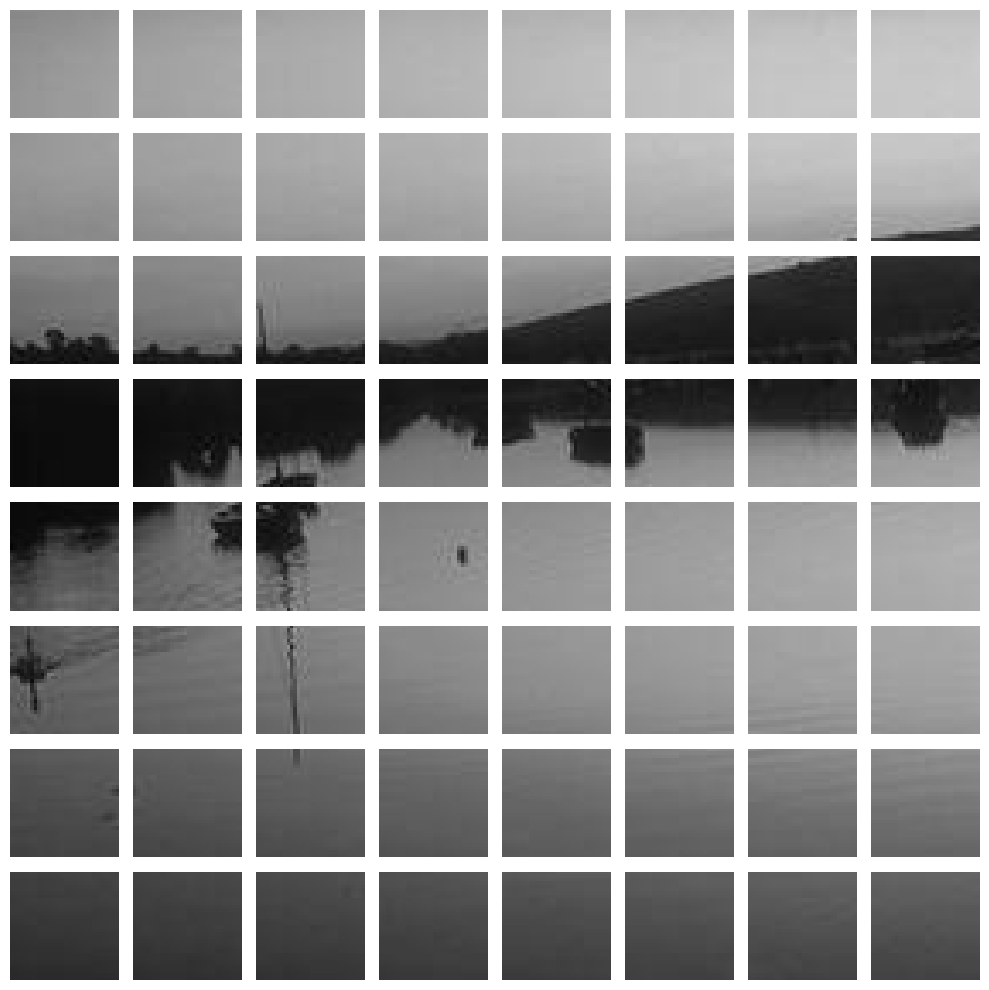

In [6]:
def plot_patches_grid(patches, patch_size, grid_shape):
    fig, axes = plt.subplots(grid_shape[0], grid_shape[1], figsize=(10, 10))
    patch_idx = 0
    for i in range(grid_shape[0]):
        for j in range(grid_shape[1]):
            if patch_idx < len(patches):
                axes[i, j].imshow(cv2.cvtColor(patches[patch_idx], cv2.COLOR_BGR2RGB))
                axes[i, j].axis('off')
                patch_idx += 1
            else:
                axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

patch_size = (32,32)

first_image_path = X_train.iloc[0]
image = cv2.imread(first_image_path)
resized_image = resize_image(image, standard_size)
patches, positions = create_patches(resized_image, patch_size)

grid_rows = resized_image.shape[0] // patch_size[0]
grid_cols = resized_image.shape[1] // patch_size[1]

plot_patches_grid(patches, patch_size, (grid_rows, grid_cols))


This is exactly what the module that's inside our "image_patching.py" do. So we now, need to save everything into the subfolders by calling that function:

In [7]:
create_images_set(X_train, X_test, y_train, y_test, patch_size, output_dir_train='patches_train', output_dir_test='patches_test')

Now, we should load our patches for training:

In [8]:
training_patches_by_category = load_patches_by_category('patches_train', y, patch_size)

### 🏋🏽‍♂️ Training phase

Now that the have our training patches stored in that variable above, we should start our analysis with PCA.

First of all, we **need to normalize and center** the data. It's so importantt that I had to emphasize it. Plus, since we are dealing with different categories, each one of them should be normalized with a different scaler (and we're going to save it for later).

In [9]:
def normalize_and_center_patches(patches, scaler=None):
    if scaler is None:
        scaler = MinMaxScaler()
        normalized_patches = scaler.fit_transform(patches)
    else:
        normalized_patches = scaler.transform(patches)

    mean = np.mean(normalized_patches, axis=0)
    normalized_centered_patches = normalized_patches - mean

    return normalized_centered_patches, scaler

normalized_centered_patches_by_category = {}
scalers_by_category = {}
for category, patches in training_patches_by_category.items():
    normalized_centered_patches, scaler = normalize_and_center_patches(patches)
    normalized_centered_patches_by_category[category] = normalized_centered_patches
    scalers_by_category[category] = scaler

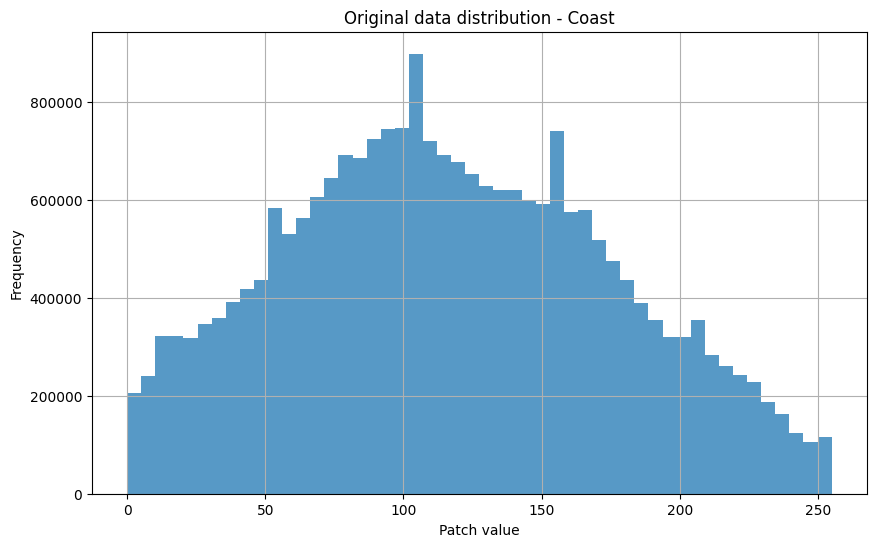

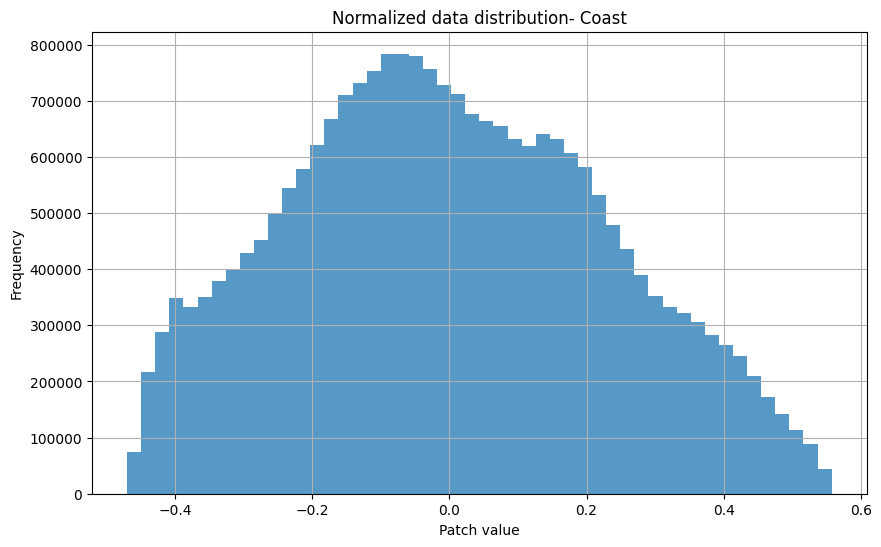

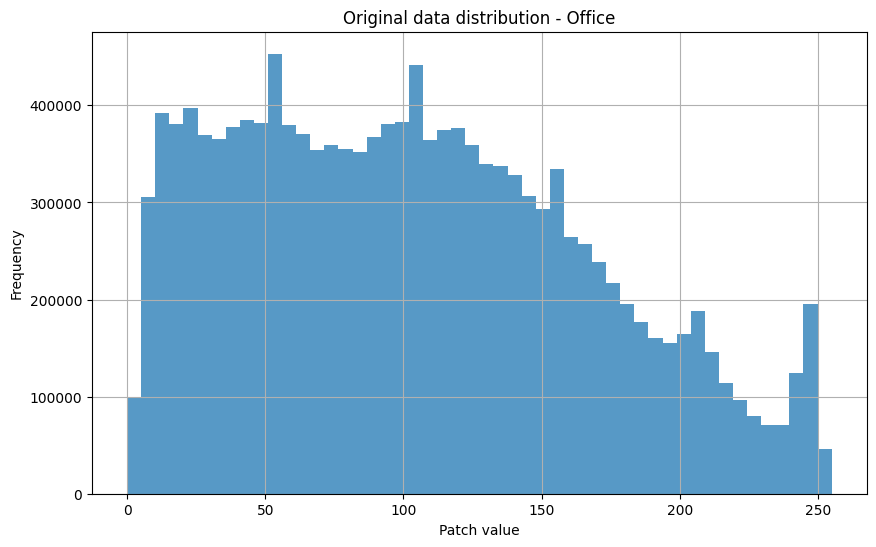

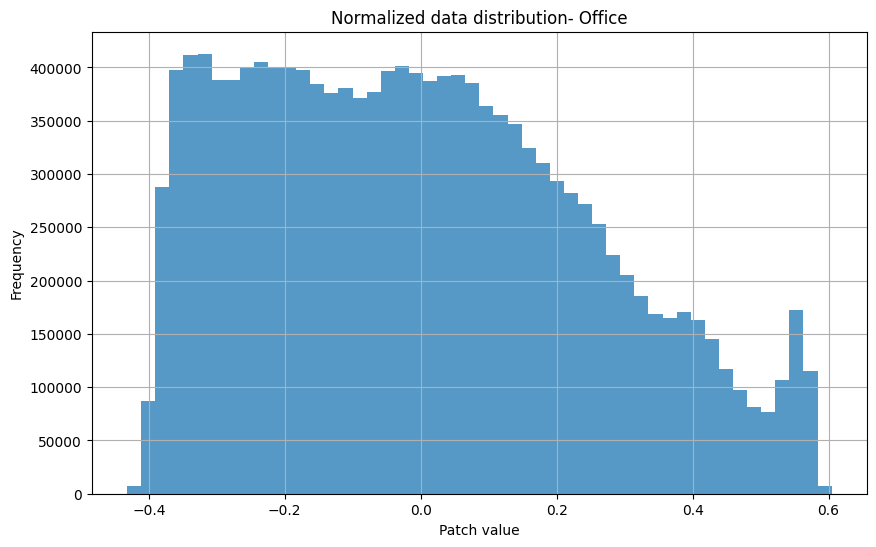

In [10]:
def plot_distribution(patches, title):
    plt.figure(figsize=(10, 6))
    plt.hist(patches.flatten(), bins=50, alpha=0.75)
    plt.title(title)
    plt.xlabel('Patch value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


for category, patches in training_patches_by_category.items():
    plot_distribution(patches, f'Original data distribution - {category}')
    plot_distribution(normalized_centered_patches_by_category[category], f'Normalized data distribution- {category}')

We see by analysing the distributions above that the MinMax has successfully normalized our data between 0 and 1.

Now let's find the PCA for the patches. Since each patch has 32x32 (1024) pixels, we're assuming that this is the initial number of components.

In [11]:
def apply_pca_and_visualize(patches_by_category, n_components=1024):
    pca_by_category = {}
    num_components_95_dict = {}
    for category, patches in patches_by_category.items():
        if patches.size == 0:
            continue 
        
        pca = PCA(n_components=n_components)
        pca.fit(patches)
        components = pca.components_
        variance = pca.explained_variance_
        
        fig, axes = plt.subplots(16, 20, figsize=(20, 16))
        for i, ax in enumerate(axes.flatten()):
            ax.imshow(components[i].reshape(32, 32), cmap='gray')
            ax.axis('off')
        plt.suptitle(f'{n_components} Principal Components  - Category: {category}')
        plt.show()
        
        plt.figure(figsize=(10, 6))
        plt.plot(np.log(variance))
        plt.title(f'Log-Variace of Principal Components - Category: {category}')
        plt.xlabel('Index of the Principal Component')
        plt.ylabel('Log-Variance')
        plt.grid(True)
        plt.show()

        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
        num_components_95 = np.where(cumulative_variance >= 0.95)[0][0] + 1

        pca = PCA(n_components=num_components_95)
        pca.fit(patches)

        pca_by_category[category] = pca
        num_components_95_dict[category] = num_components_95

        print("Category: " + category)
        print("Number of components that explain 95% of variance: " + str(num_components_95))

    
    min_num_components = min(num_components_95_dict.values())
    return pca_by_category,num_components_95_dict, min_num_components

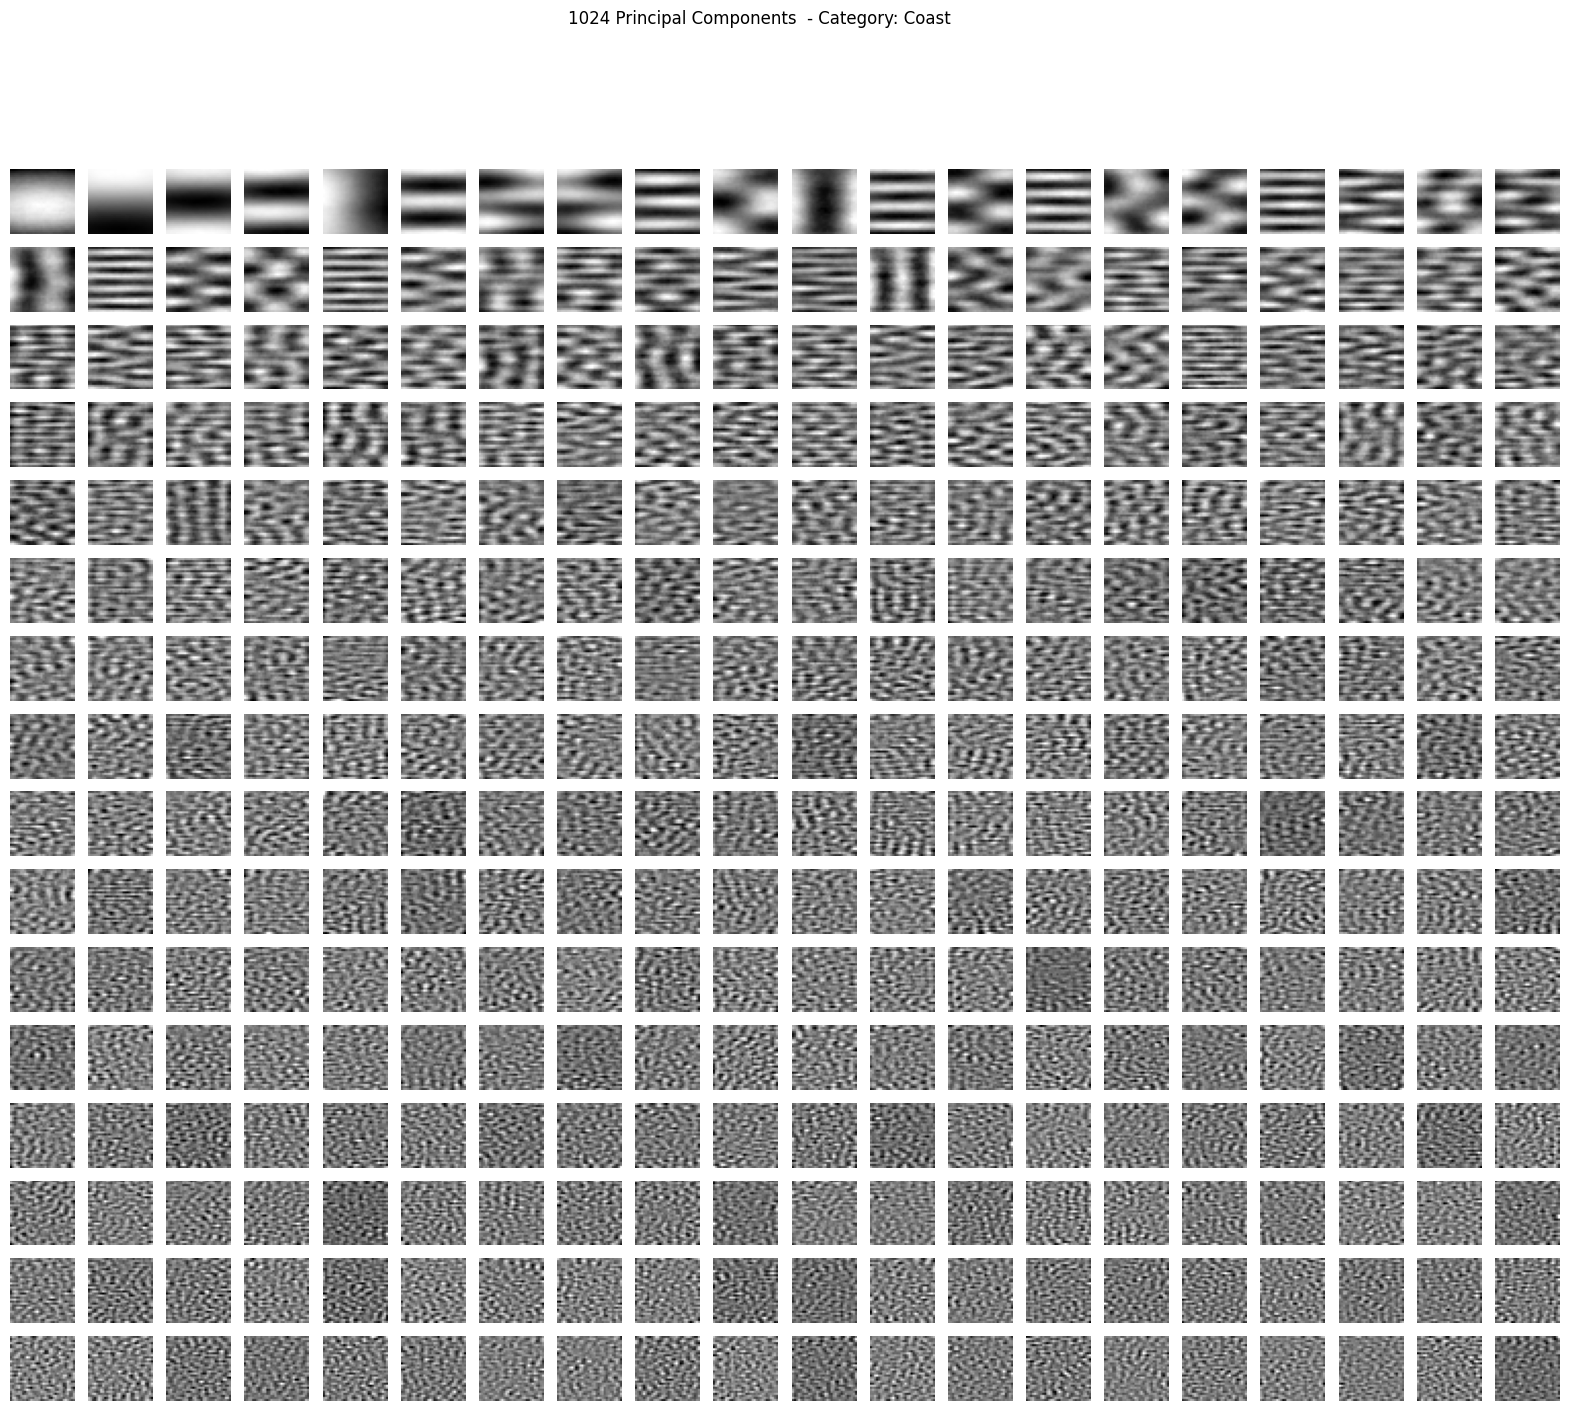

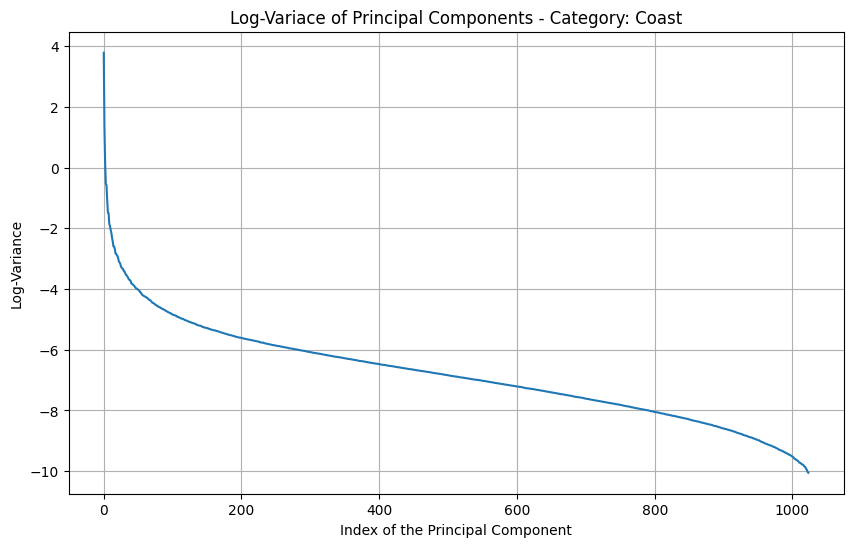

Category: Coast
Number of components that explain 95% of variance: 23


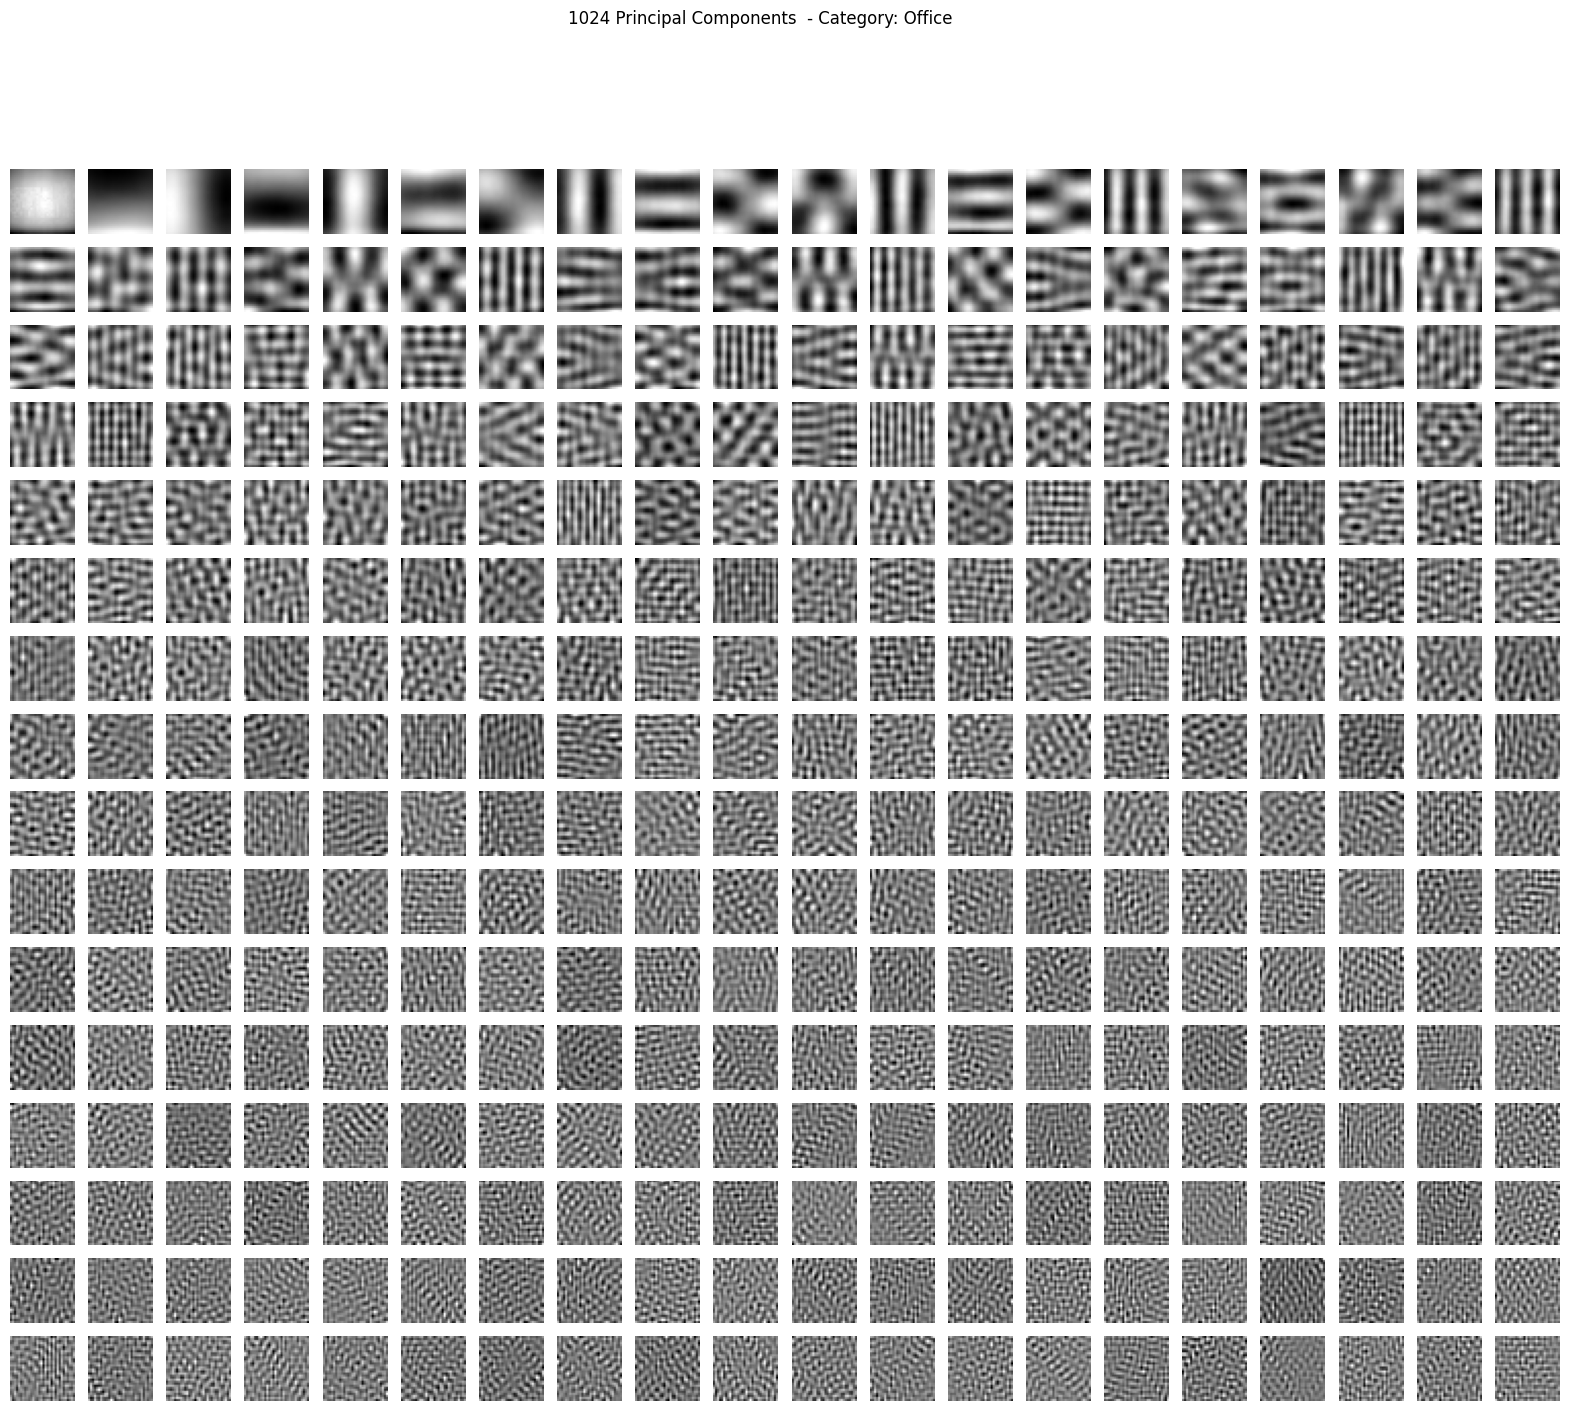

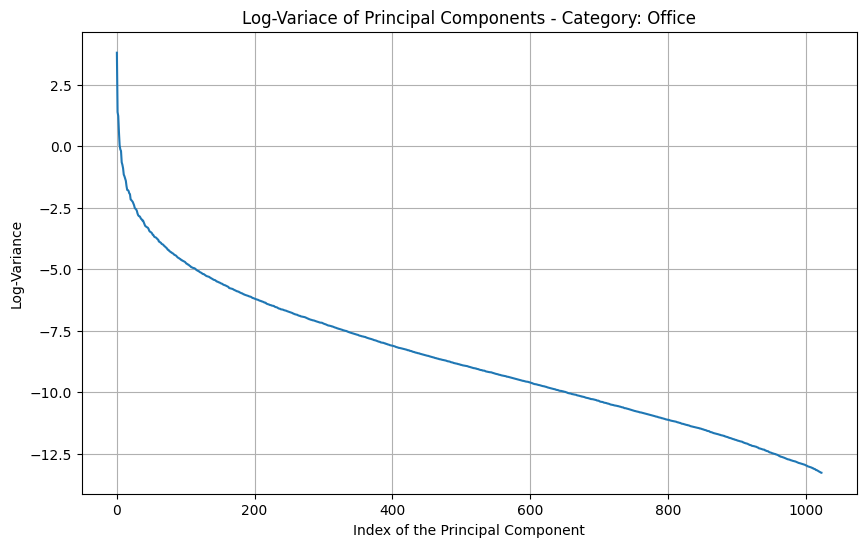

Category: Office
Number of components that explain 95% of variance: 22


In [12]:
pca_by_category, nummin_components_99_dict, min_components = apply_pca_and_visualize(normalized_centered_patches_by_category)

So now, we see that for the "Coast" we only need 23 from 1024 components to explain 95% of the variance in the patch. For the "Office", it is reduced to 22.

The variable that stores the PCA is populated with the PCA that has these minimal description components number.

We can double check it with the following graph:

Category: Coast
Explained Variance Ratio: [0.80184844 0.06827108 0.02166538 0.01075211 0.01019459 0.00624711
 0.00416557 0.00410485 0.00286764 0.00267285 0.00236359 0.00214423
 0.00181925 0.00161856 0.00136771 0.0013524  0.00126562 0.00108741
 0.0010639  0.00102021 0.00099619 0.00091465 0.00082328]
Cumulative Explained Variance: [0.80184844 0.87011952 0.8917849  0.902537   0.9127316  0.91897871
 0.92314428 0.92724913 0.93011677 0.93278962 0.93515322 0.93729744
 0.9391167  0.94073525 0.94210297 0.94345536 0.94472099 0.9458084
 0.94687229 0.94789251 0.9488887  0.94980335 0.95062662]
Number of components to explain 95% variance: 23


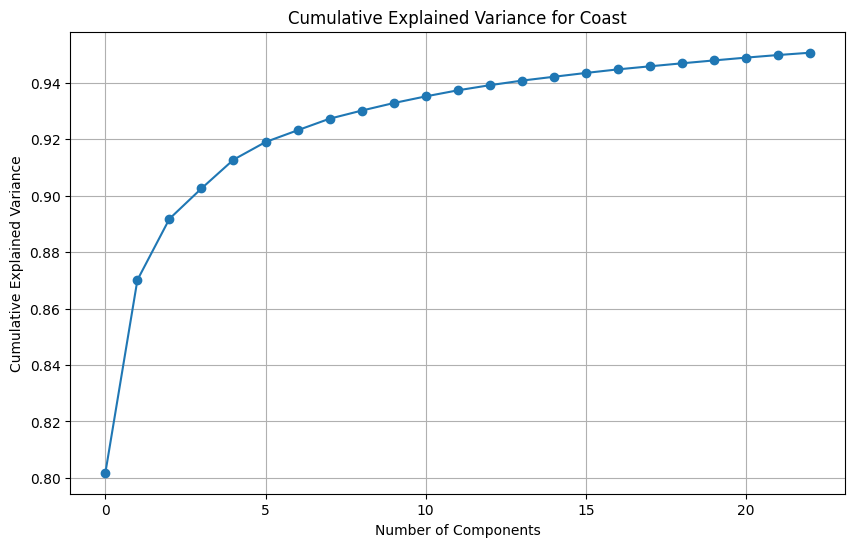

Category: Office
Explained Variance Ratio: [0.70395763 0.06321063 0.05374717 0.02798465 0.01643146 0.01386981
 0.01301668 0.00823057 0.00743287 0.00644513 0.00498717 0.00465678
 0.00425846 0.00387065 0.00311667 0.00267289 0.00264977 0.00256129
 0.00232775 0.00225527 0.00181297 0.00177063]
Cumulative Explained Variance: [0.70395763 0.76716826 0.82091543 0.84890008 0.86533153 0.87920135
 0.89221802 0.90044859 0.90788146 0.91432659 0.91931376 0.92397055
 0.92822901 0.93209966 0.93521633 0.93788922 0.94053898 0.94310028
 0.94542802 0.94768329 0.94949626 0.9512669 ]
Number of components to explain 95% variance: 22


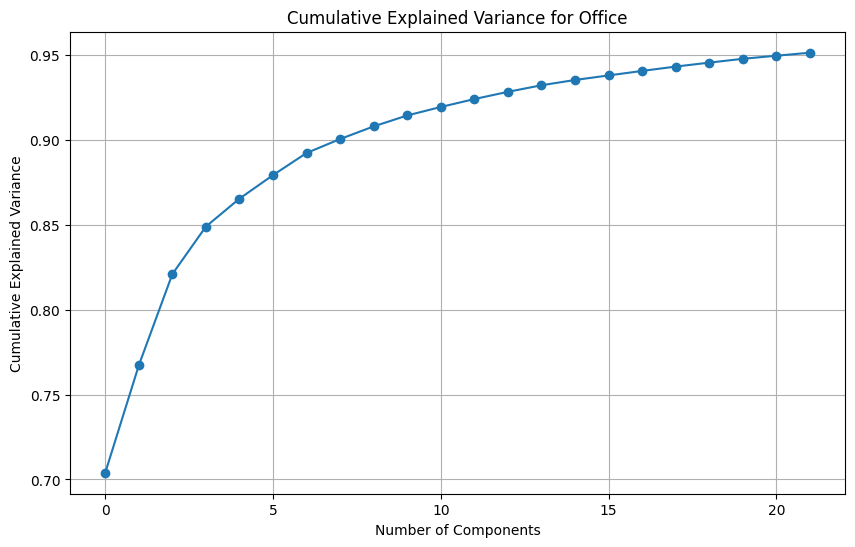

In [13]:
def print_explained_variance_ratio(pca_by_category):
    for category, pca in pca_by_category.items():
        explained_variance_ratio = pca.explained_variance_ratio_
        cumulative_explained_variance = np.cumsum(explained_variance_ratio)
        print(f"Category: {category}")
        print(f"Explained Variance Ratio: {explained_variance_ratio}")
        print(f"Cumulative Explained Variance: {cumulative_explained_variance}")

        if np.any(cumulative_explained_variance >= 0.95):
            num_components_95 = np.where(cumulative_explained_variance >= 0.95)[0][0] + 1
            print(f"Number of components to explain 95% variance: {num_components_95}")
        else:
            max_cumulative_variance = cumulative_explained_variance[-1]
            print(f"Maximum cumulative explained variance is: {max_cumulative_variance:.5f}")

        plt.figure(figsize=(10, 6))
        plt.plot(cumulative_explained_variance, marker='o')
        plt.title(f'Cumulative Explained Variance for {category}')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.grid(True)
        plt.show()

print_explained_variance_ratio(pca_by_category)

We can also check it visually, by reconstructing the images and assuring that the main features are somewhat relatable to the original image:

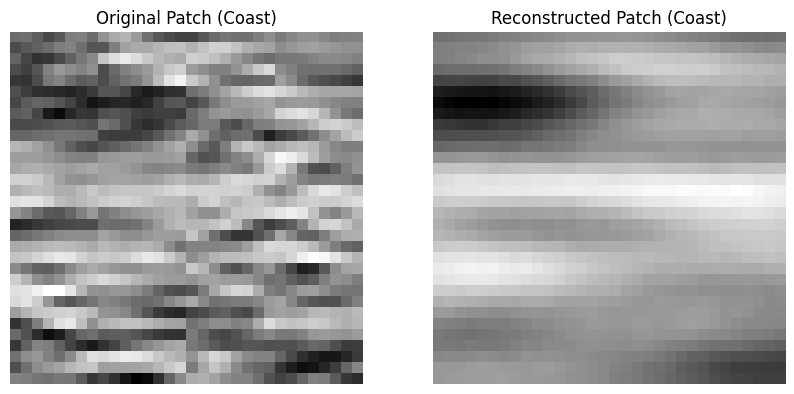

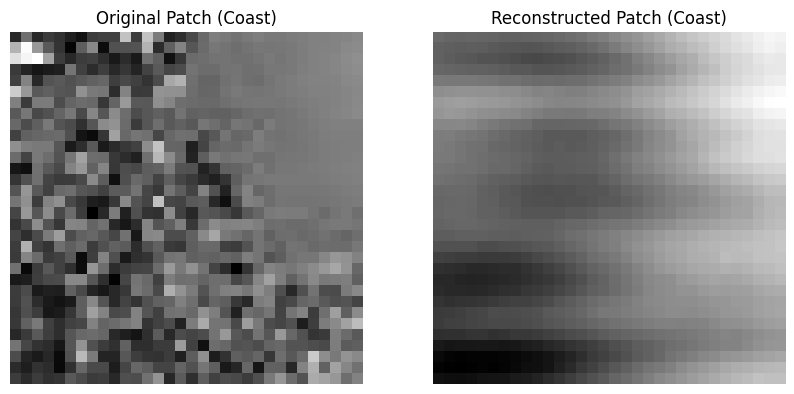

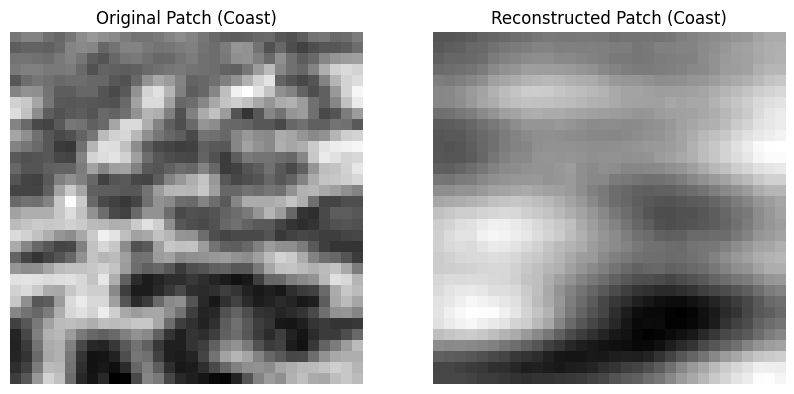

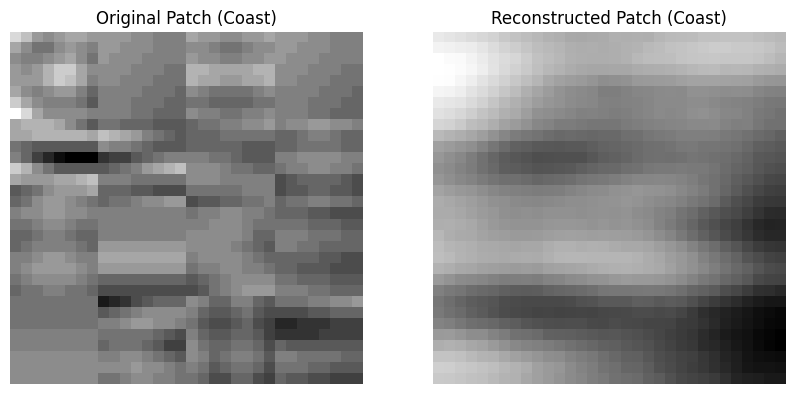

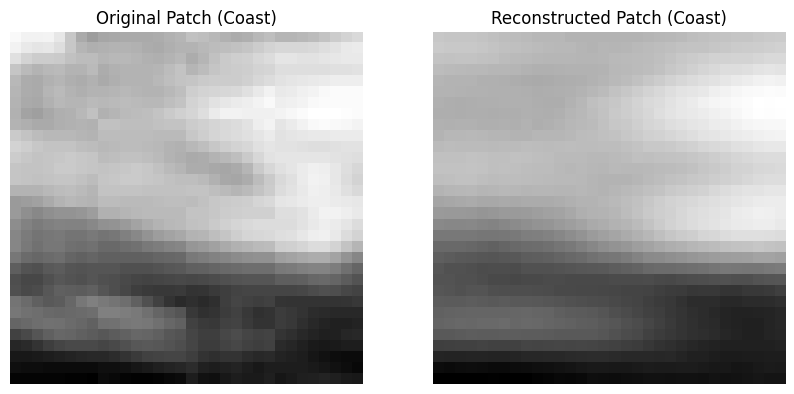

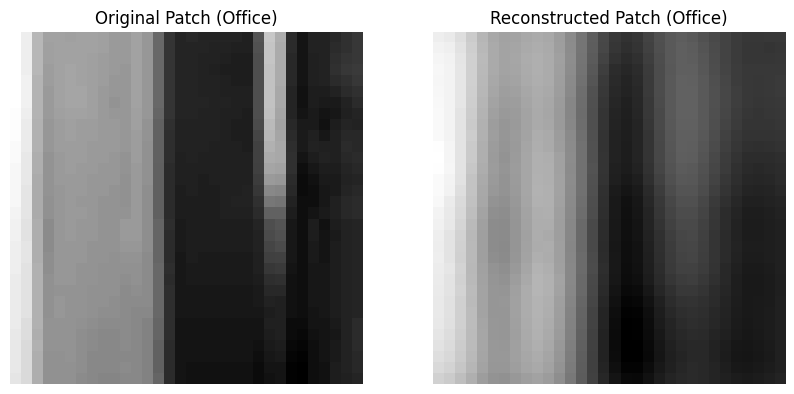

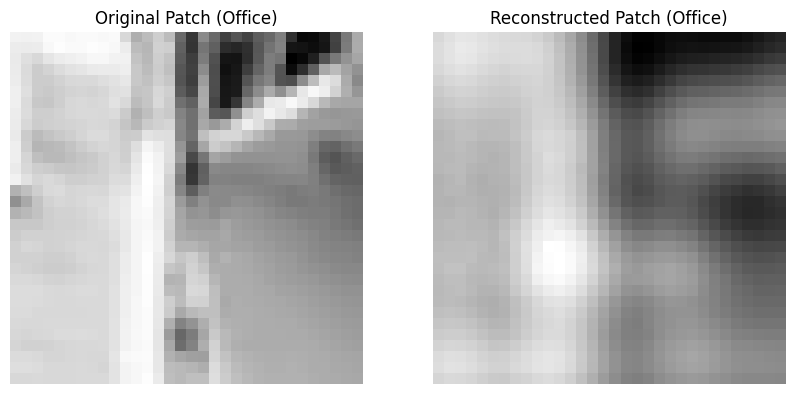

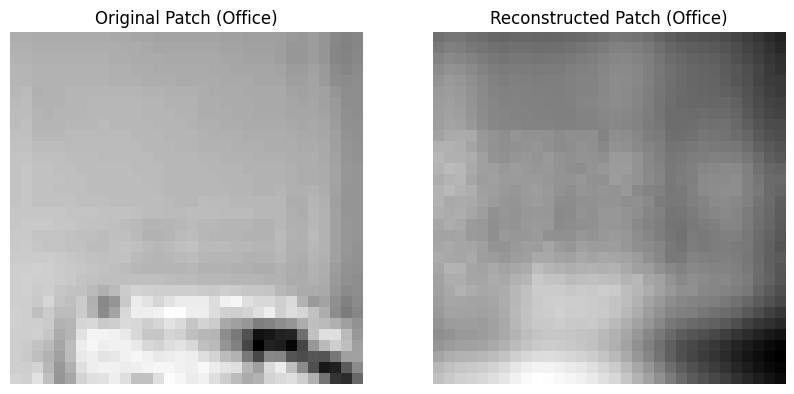

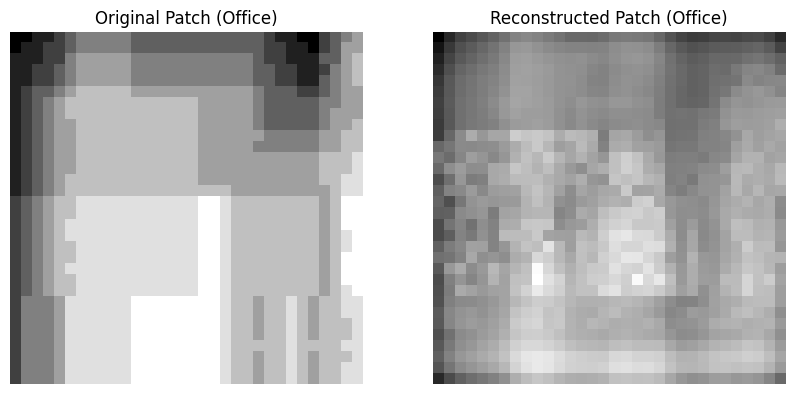

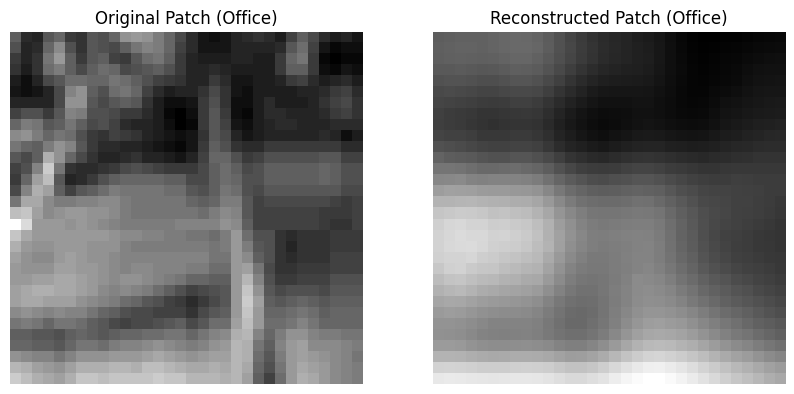

In [14]:
def visualize_reconstructed_images(pca_by_category, patches_by_category, n_samples=5):
    for category, pca in pca_by_category.items():
        category_name = str(category)
        patches = patches_by_category[category]
        
        sample_indices = np.random.choice(patches.shape[0], n_samples, replace=False)
        for idx in sample_indices:
            original_patch = patches[idx].reshape(32, 32)
            reconstructed_patch = pca.inverse_transform(pca.transform(patches[idx].reshape(1, -1))).reshape(32, 32)
            
            plt.figure(figsize=(10, 5))
            
            # Original patch
            plt.subplot(1, 2, 1)
            plt.imshow(original_patch, cmap='gray')
            plt.title(f'Original Patch ({category_name})')
            plt.axis('off')
            
            # Reconstructed patch
            plt.subplot(1, 2, 2)
            plt.imshow(reconstructed_patch, cmap='gray')
            plt.title(f'Reconstructed Patch ({category_name})')
            plt.axis('off')
            
            plt.show()

visualize_reconstructed_images(pca_by_category, training_patches_by_category)


## ⚗️ Test phase

Now we should start our experimenting phas.
We bein by loading the test dataset.

In [15]:
test_patches_by_category = load_patches_by_category('patches_test', y, patch_size)

Now we should compute the projection into the residual space of a given data. The main logic here is to:

In [47]:
# Função para calcular os resíduos usando PCA
def compute_residuals_with_pca(patches, pca):
    projected_data = pca.transform(patches)
    reconstructed_data = pca.inverse_transform(projected_data)
    residuals = patches - reconstructed_data
    return residuals, reconstructed_data

# Função para calcular a medida OOD com base nos resíduos
def calculate_ood(patches, residuals):
    residual_norms = np.linalg.norm(residuals, axis=1)
    original_norms = np.linalg.norm(patches, axis=1)
    ood_scores = residual_norms / original_norms
    return ood_scores

In [52]:
# Calcular OOD scores para os dados de teste
for test_category, test_patches in test_patches_by_category.items():
    ood_scores = {}
    for train_category in train_categories:
        # Normalizar e centralizar os dados de teste usando o scaler da categoria de treinamento
        normalized_centered_test_patches, _ = normalize_and_center_patches(test_patches, scalers_by_category[train_category])
        
        # Obter o PCA da categoria de treinamento
        pca = pca_by_category[train_category]
        
        # Calcular os resíduos
        residuals, reconstructed = compute_residuals_with_pca(normalized_centered_test_patches, pca)
        
        # Verificações de forma
        print(f"Shape of normalized_centered_test_patches: {normalized_centered_test_patches.shape}")
        print(f"Reconstructed = {reconstructed}")
        print(f"Shape of residuals: {residuals.shape}")
        print(f"Residuals = {residuals}")
        
        if normalized_centered_test_patches.shape != residuals.shape:
            raise ValueError("Shapes of normalized_centered_test_patches and residuals do not match.")
        
        # Calcular as medidas OOD
        scores = calculate_ood(normalized_centered_test_patches, residuals)
        ood_scores[train_category] = np.mean(scores)
    
    # Identificar a melhor categoria de treinamento (menor OOD score)
    best_environment = min(ood_scores, key=ood_scores.get)
    
    # Output formatado
    print(f"Test category: {test_category}")
    print(f"Best environment: {best_environment}")
    print(f"OOD scores: {ood_scores}")
    print()  # Linha em branco para separar as saídas

Shape of normalized_centered_test_patches: (11904, 1024)
Reconstructed = [[-0.15742396 -0.15468723 -0.15196866 ... -0.38020781 -0.37754932
  -0.37500319]
 [-0.24568749 -0.24386175 -0.24478082 ... -0.0998187  -0.09404322
  -0.09284177]
 [ 0.05766589  0.06087359  0.05735852 ...  0.02190595  0.03284746
   0.03524946]
 ...
 [-0.27361416 -0.28698178 -0.29973862 ...  0.5312656   0.53190428
   0.528913  ]
 [-0.29115869 -0.30450062 -0.31670075 ...  0.37825398  0.37917174
   0.37747716]
 [-0.27596881 -0.26630166 -0.25642384 ... -0.22699579 -0.21390597
  -0.20834495]]
Shape of residuals: (11904, 1024)
Residuals = [[-0.01692607 -0.01250356 -0.00786491 ...  0.00056873 -0.00503357
  -0.05435191]
 [-0.17179979 -0.1037212  -0.07975863 ...  0.01821885  0.00165641
   0.02819255]
 [ 0.02680761  0.02291601  0.0220236  ...  0.03767066 -0.04288133
   0.05696407]
 ...
 [-0.16348097 -0.14687568 -0.13068319 ... -0.00502232 -0.00468324
  -0.00140535]
 [-0.14201486 -0.12935685 -0.11764263 ... -0.00495188 -0.008

In [53]:
from collections import Counter

def categorize_test_images(test_patches, pca_by_category, scalers_by_category):
    categories = list(pca_by_category.keys())
    predictions = []
    test_patches_normalized, _ = normalize_and_center_patches(test_patches, scaler)
    min_error = float('inf')
    best_category = None
    for category in categories:
        residuals, reconstructed = compute_residuals_with_pca(test_patches_normalized, pca_by_category[category])
        reconstruction_error_norm = np.linalg.norm(residuals)
        reconstruction_error = reconstruction_error_norm / np.linalg.norm(reconstructed)
        print(f"Reconstruction error {category} = {reconstruction_error}")
        if reconstruction_error < min_error:
            min_error = reconstruction_error
            best_category = category
    predictions.append(best_category)
    return predictions

def determine_final_category(predictions):
    category_count = Counter(predictions)
    final_category = category_count.most_common(1)[0][0]
    return final_category

In [54]:
for test_category, test_patches in test_patches_by_category.items():
    predictions = categorize_test_images(test_patches, pca_by_category, scalers_by_category)
    final_category = determine_final_category(predictions)
    print(f"Test category: {test_category}")
    print(f"Predictions: {predictions}")
    print(f"Final category: {final_category}")


Reconstruction error Coast = 0.23307598211263172
Reconstruction error Office = 0.2458556818871987
Test category: Coast
Predictions: ['Coast']
Final category: Coast
Reconstruction error Coast = 0.2542435683818783
Reconstruction error Office = 0.2316830959646005
Test category: Office
Predictions: ['Office']
Final category: Office


## ✌️ Part II: Comparing two similar environments

In [55]:
train_categories = ['Bedroom', 'LivingRoom']

df_similar = df[df['category'].isin(train_categories)]
df_similar

image_path    category
0        ../data/CBIR_15-Scene/00/1.jpg     Bedroom
1        ../data/CBIR_15-Scene/00/2.jpg     Bedroom
2        ../data/CBIR_15-Scene/00/3.jpg     Bedroom
3        ../data/CBIR_15-Scene/00/4.jpg     Bedroom
4        ../data/CBIR_15-Scene/00/5.jpg     Bedroom
...                                 ...         ...
1262  ../data/CBIR_15-Scene/04/1263.jpg  LivingRoom
1263  ../data/CBIR_15-Scene/04/1264.jpg  LivingRoom
1264  ../data/CBIR_15-Scene/04/1265.jpg  LivingRoom
1265  ../data/CBIR_15-Scene/04/1266.jpg  LivingRoom
1266  ../data/CBIR_15-Scene/04/1267.jpg  LivingRoom

[505 rows x 2 columns]

In [56]:
X = df_similar['image_path']
y = df_similar['category']
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, random_state=10)


In [58]:
create_images_set(X_train, X_test, y_train, y_test, patch_size, output_dir_train='patches_train', output_dir_test='patches_test')

In [59]:
training_patches_by_category = load_patches_by_category('patches_train', y, patch_size)

In [60]:
normalized_centered_patches_by_category = {}
scalers_by_category = {}
for category, patches in training_patches_by_category.items():
    normalized_centered_patches, scaler = normalize_and_center_patches(patches)
    normalized_centered_patches_by_category[category] = normalized_centered_patches
    scalers_by_category[category] = scaler

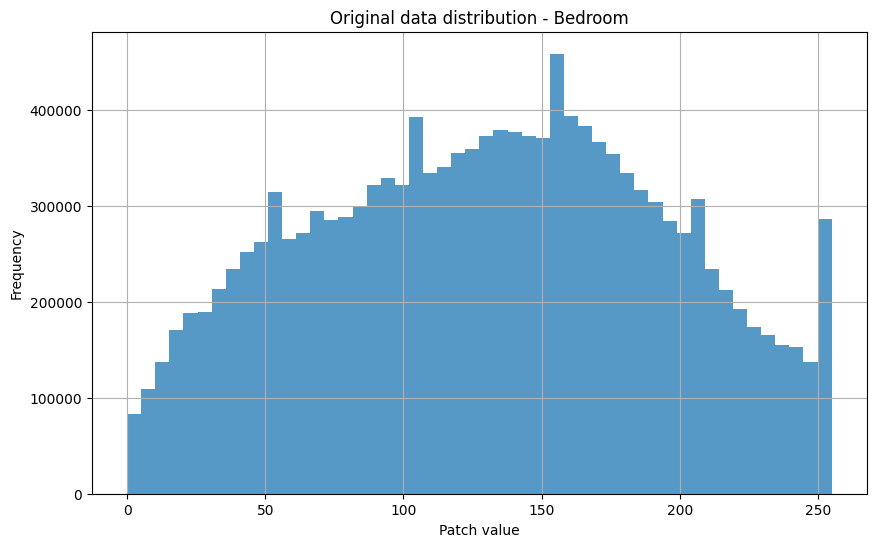

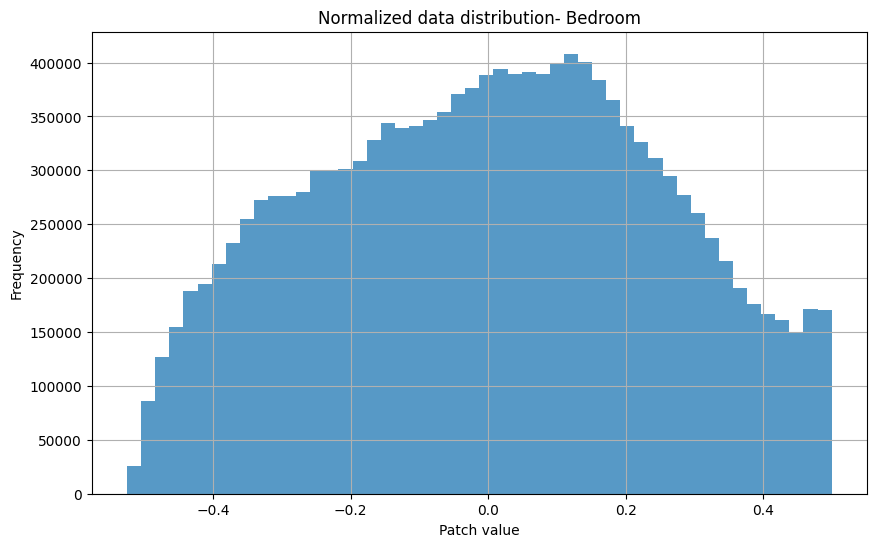

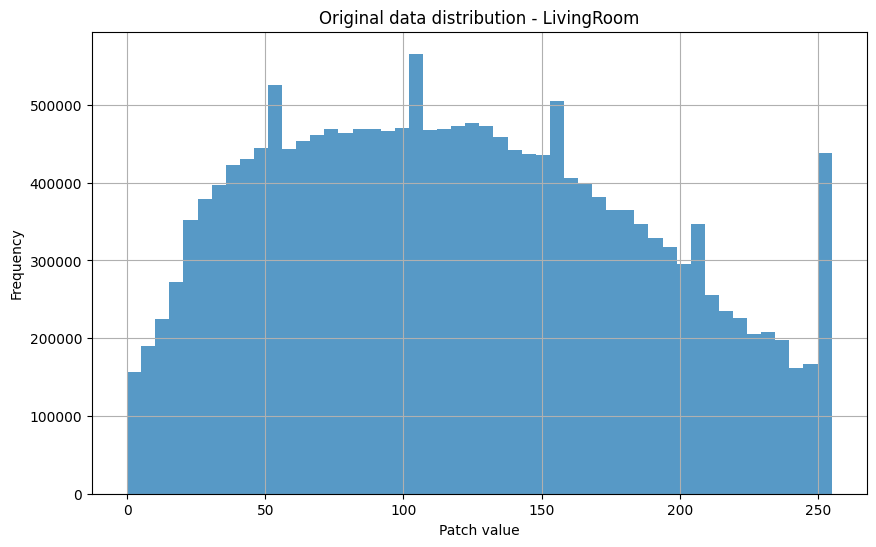

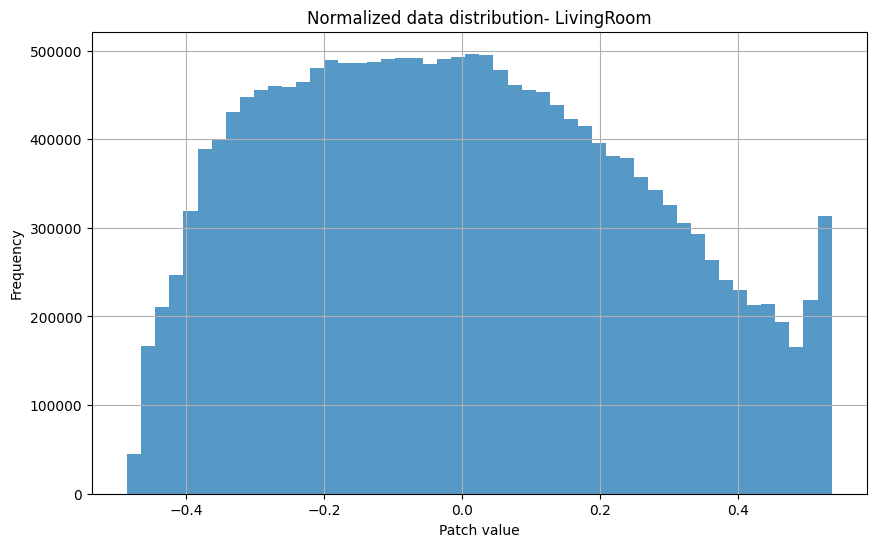

In [61]:
for category, patches in training_patches_by_category.items():
    plot_distribution(patches, f'Original data distribution - {category}')
    plot_distribution(normalized_centered_patches_by_category[category], f'Normalized data distribution- {category}')

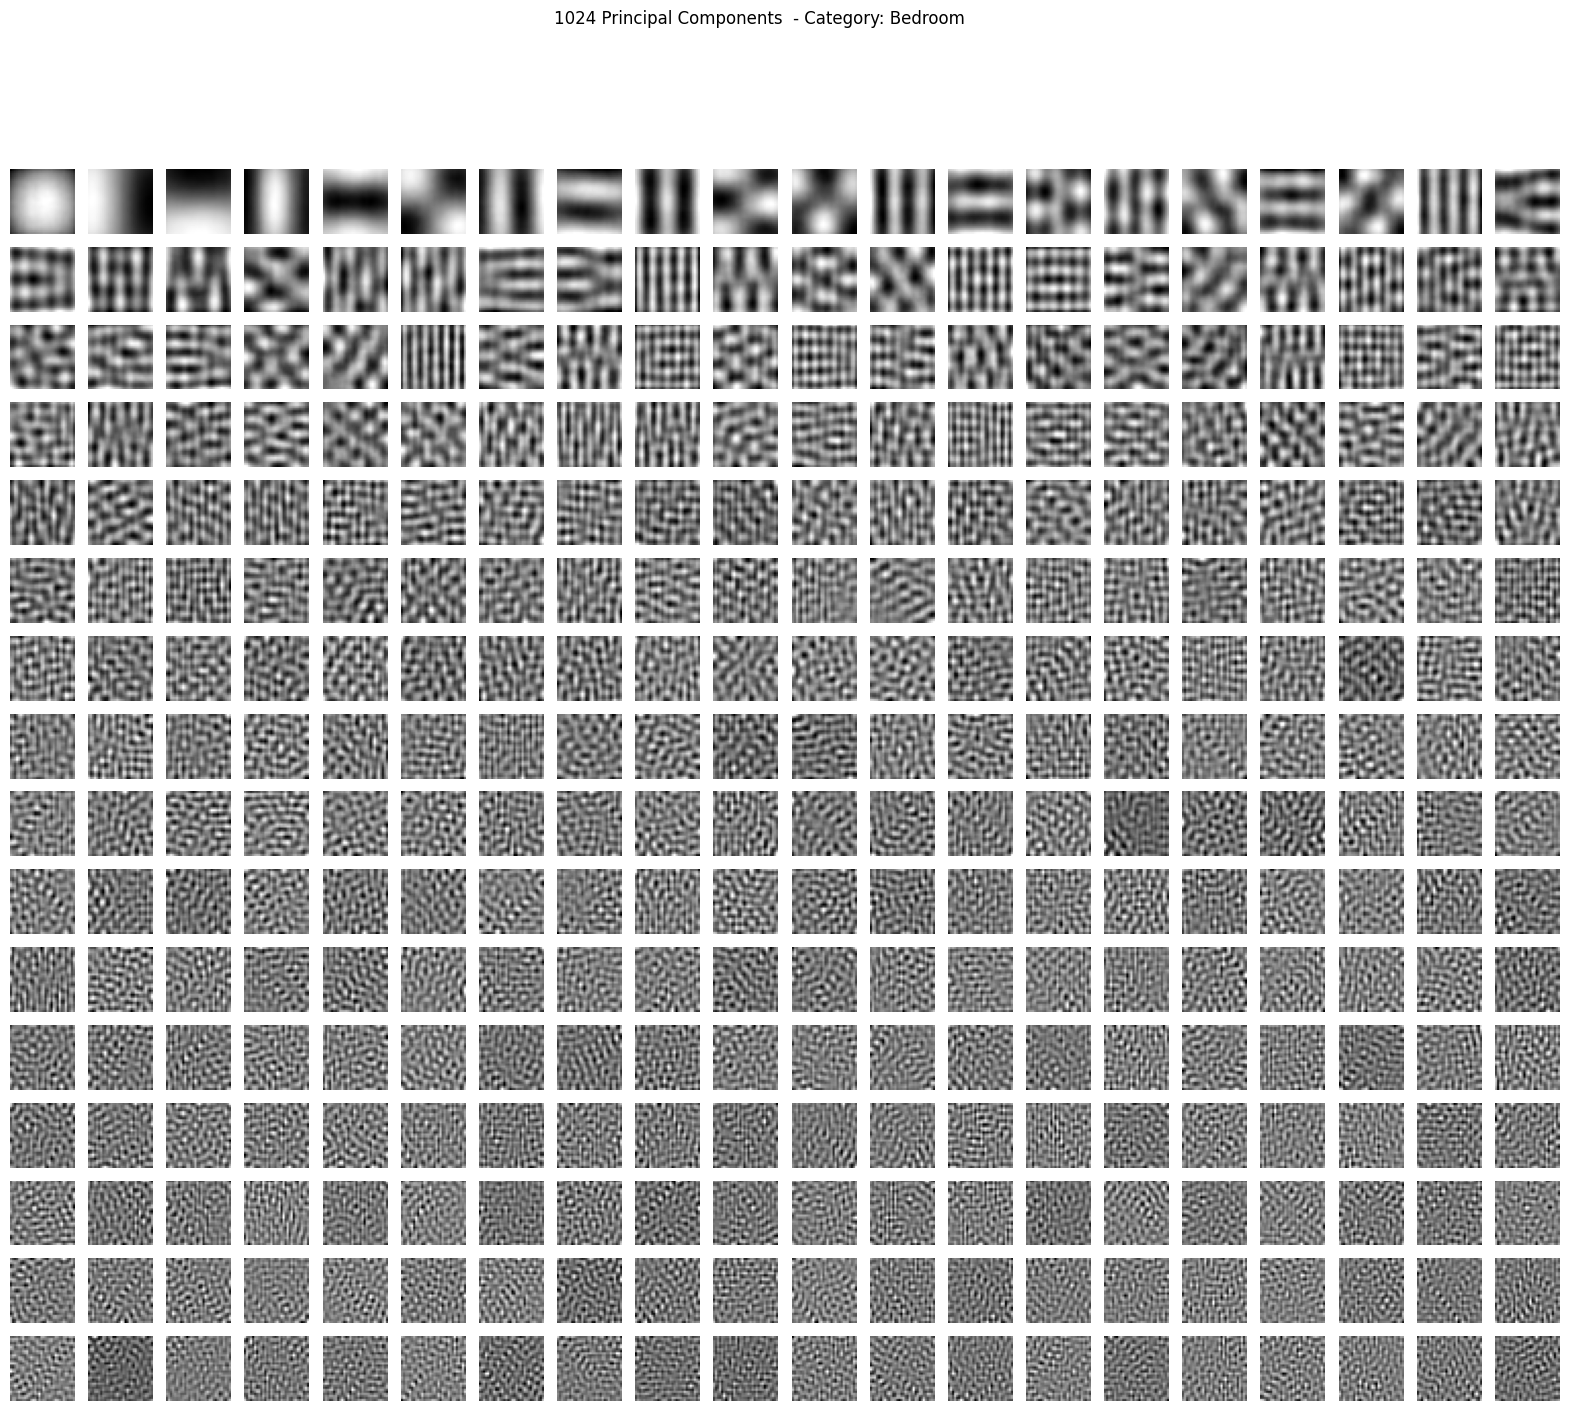

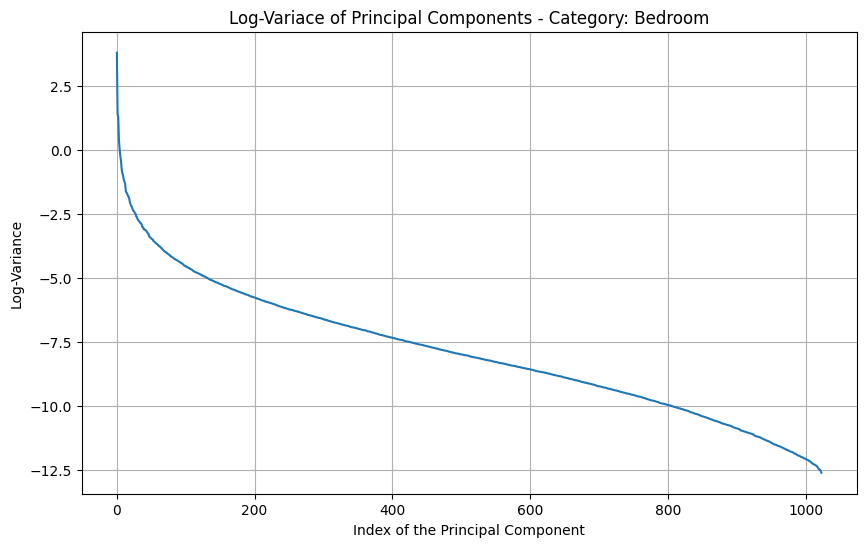

Category: Bedroom
Number of components that explain 95% of variance: 27


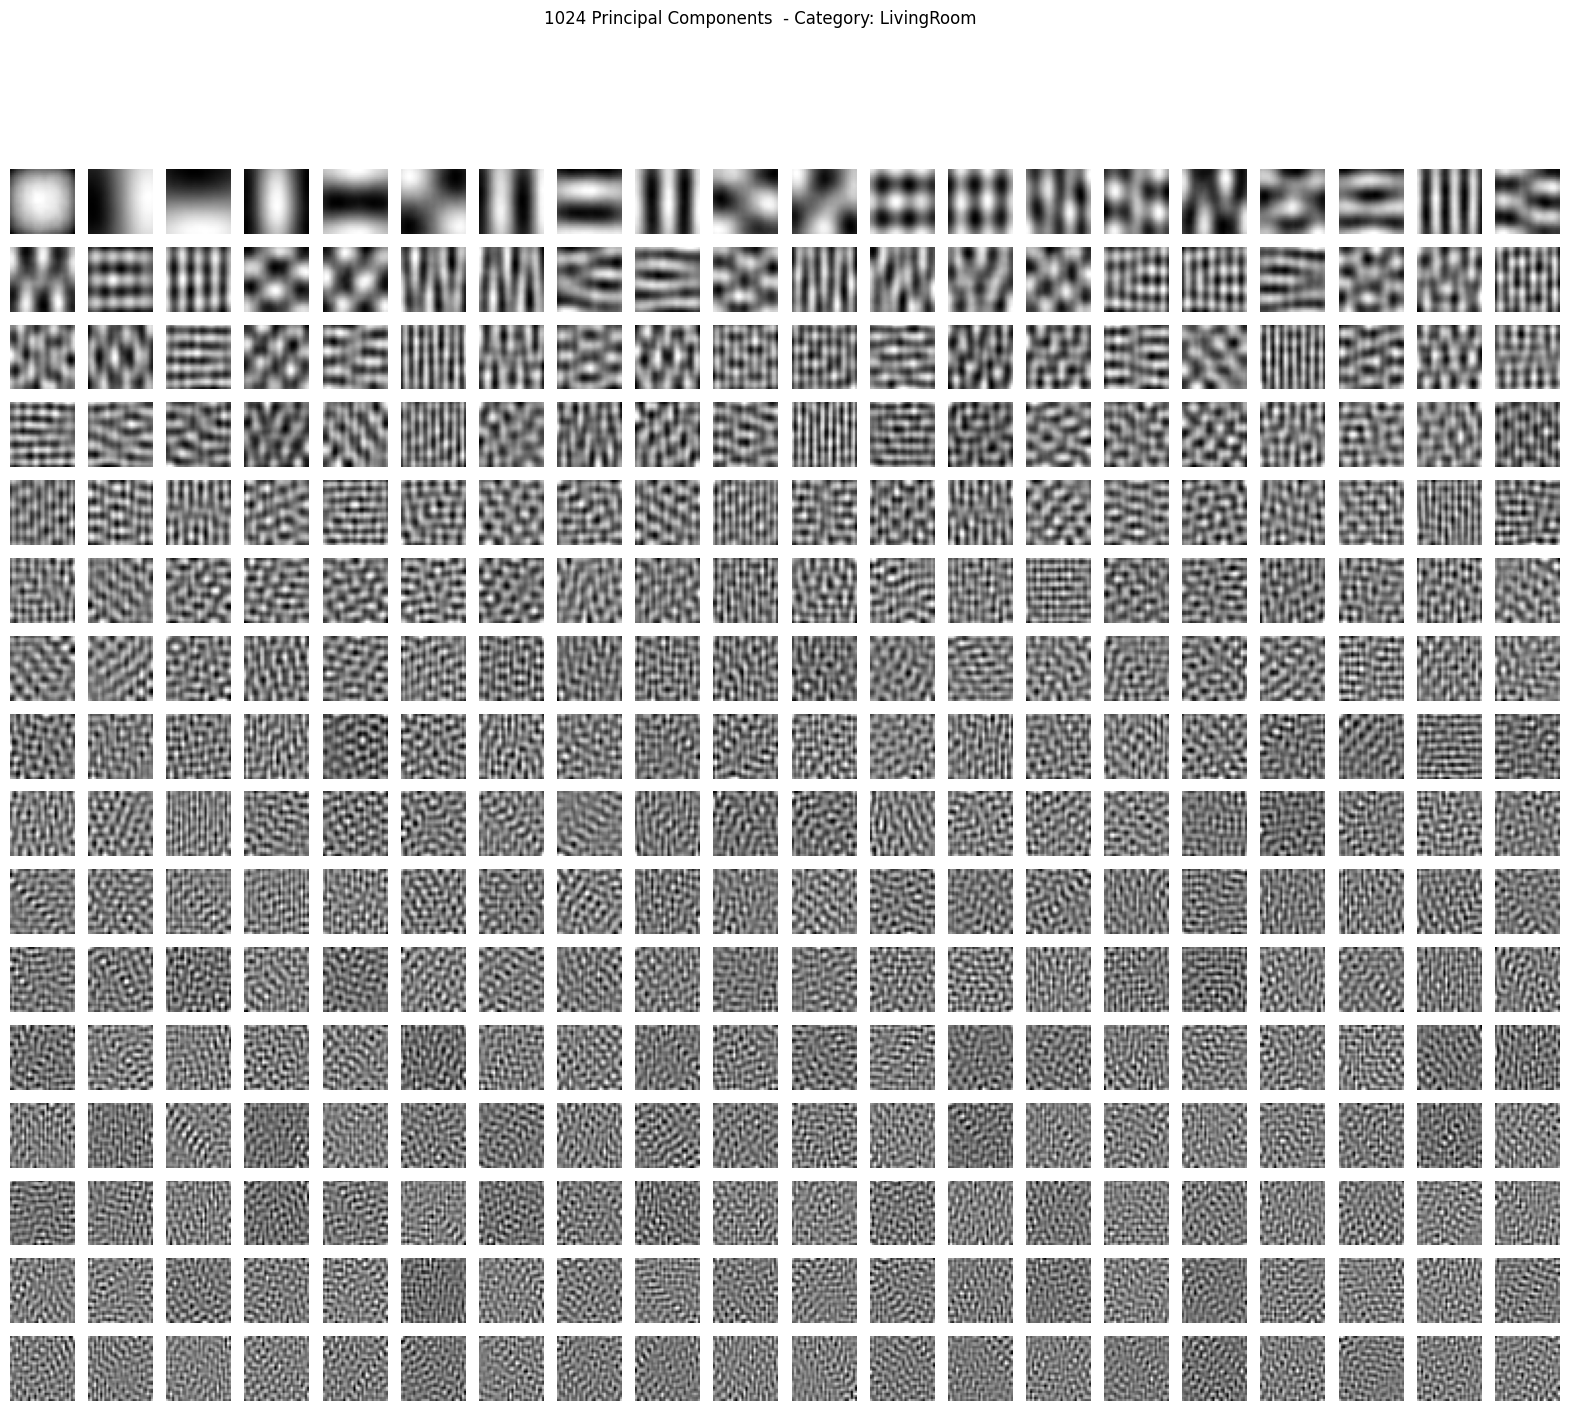

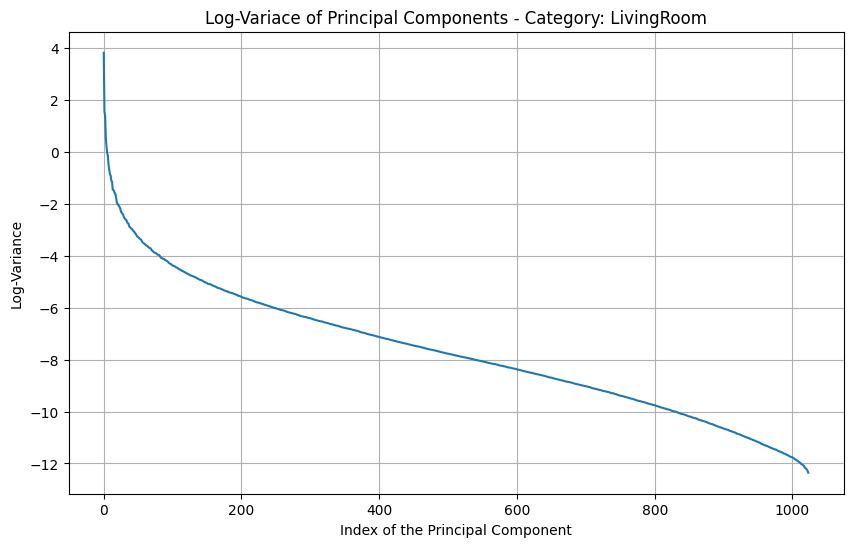

Category: LivingRoom
Number of components that explain 95% of variance: 31


In [62]:
pca_by_category, nummin_components_99_dict, min_components = apply_pca_and_visualize(normalized_centered_patches_by_category)

Category: Bedroom
Explained Variance Ratio: [0.70576011 0.06412086 0.05693522 0.02288178 0.01630417 0.01244662
 0.01022835 0.0073553  0.00625028 0.00579983 0.00490421 0.00455293
 0.00421454 0.00312687 0.00298906 0.00280583 0.00265656 0.00251305
 0.0023324  0.00200381 0.00185942 0.00175184 0.00168828 0.0015389
 0.00145694 0.00142065 0.00135333]
Cumulative Explained Variance: [0.70576011 0.76988096 0.82681619 0.84969796 0.86600213 0.87844875
 0.8886771  0.89603239 0.90228268 0.90808251 0.91298672 0.91753965
 0.92175419 0.92488106 0.92787012 0.93067595 0.93333251 0.93584557
 0.93817797 0.94018178 0.9420412  0.94379303 0.94548131 0.9470202
 0.94847714 0.94989779 0.95125112]
Number of components to explain 95% variance: 27


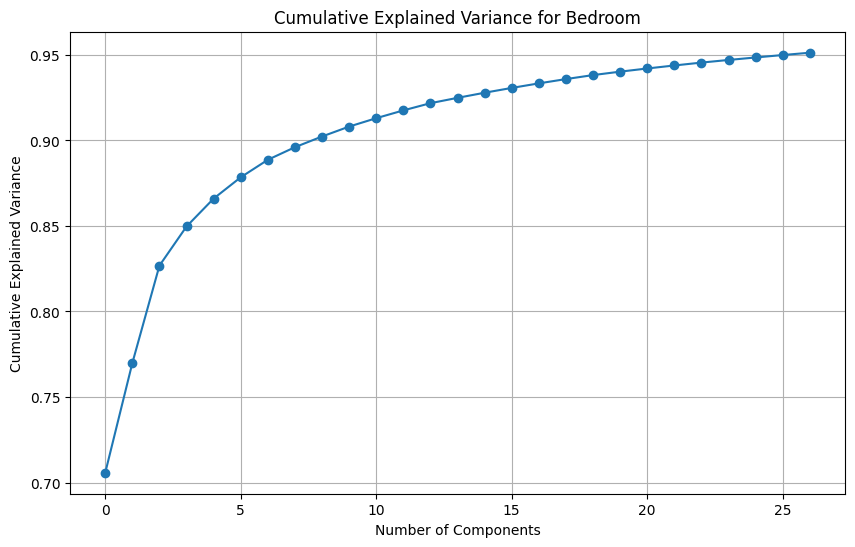

Category: LivingRoom
Explained Variance Ratio: [0.67458692 0.06978651 0.05955206 0.02559123 0.01833246 0.01406921
 0.01273898 0.00888037 0.00739575 0.00628344 0.00597582 0.00487305
 0.0047343  0.00347304 0.00341804 0.00325469 0.00297725 0.00292632
 0.00253153 0.00209143 0.0020168  0.00191295 0.00186172 0.00176551
 0.00167348 0.00146949 0.00143427 0.00136902 0.00133782 0.00122384
 0.00115065]
Cumulative Explained Variance: [0.67458692 0.74437343 0.80392549 0.82951672 0.84784917 0.86191839
 0.87465737 0.88353774 0.89093349 0.89721694 0.90319275 0.9080658
 0.9128001  0.91627314 0.91969118 0.92294587 0.92592312 0.92884944
 0.93138097 0.9334724  0.9354892  0.93740215 0.93926387 0.94102938
 0.94270286 0.94417235 0.94560662 0.94697564 0.94831346 0.9495373
 0.95068795]
Number of components to explain 95% variance: 31


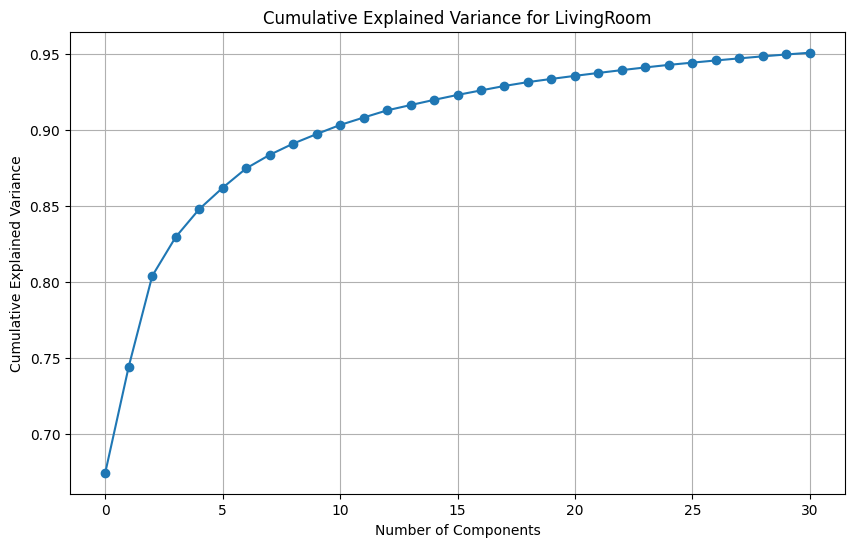

In [63]:
print_explained_variance_ratio(pca_by_category)

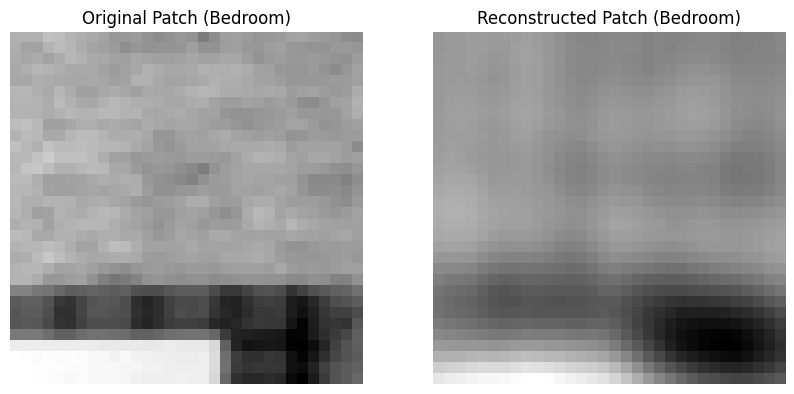

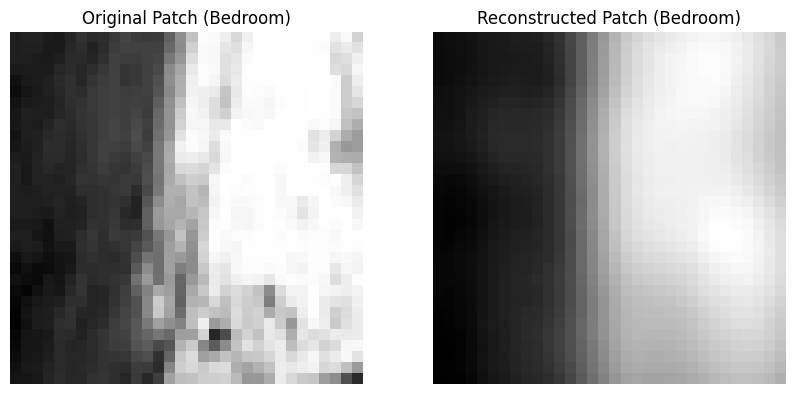

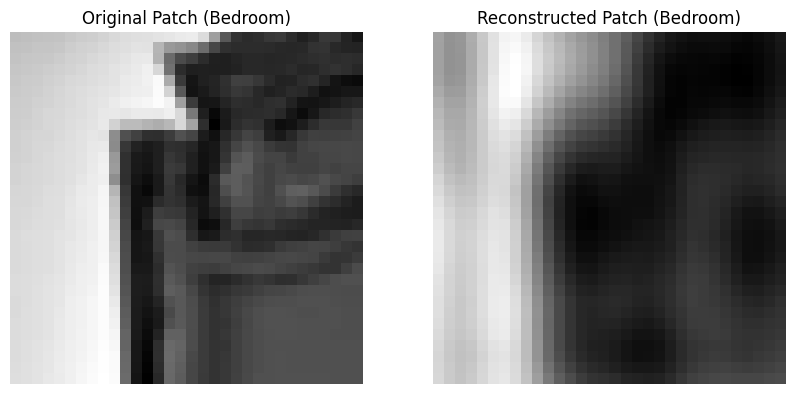

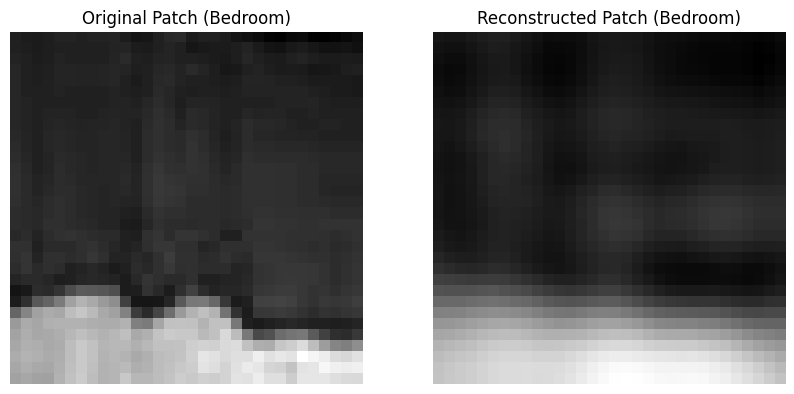

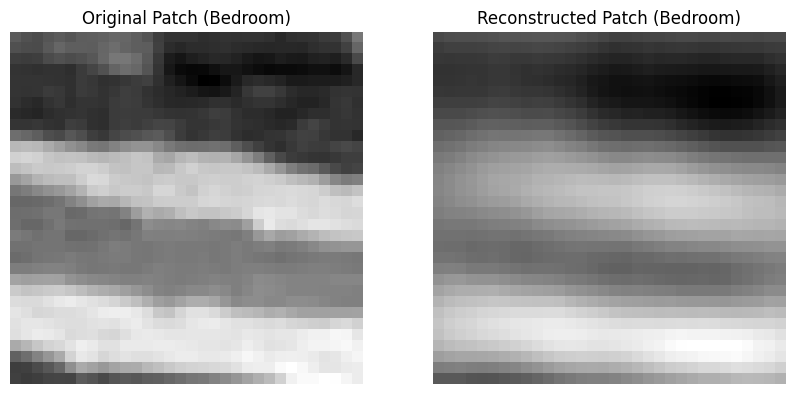

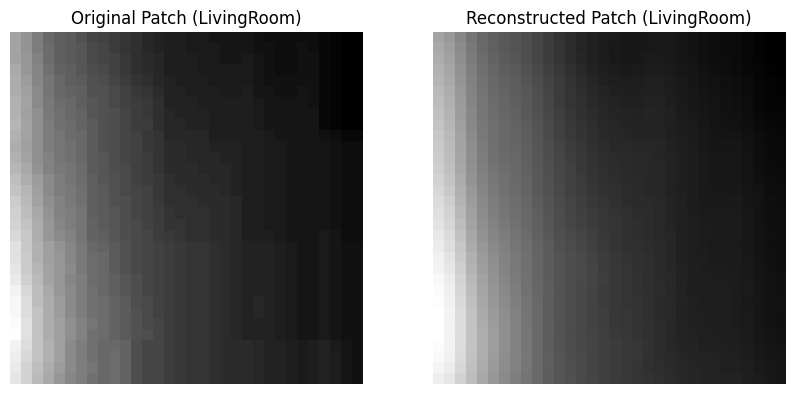

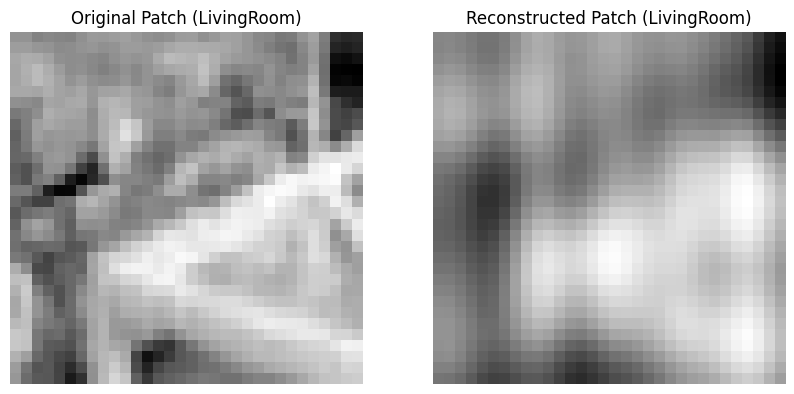

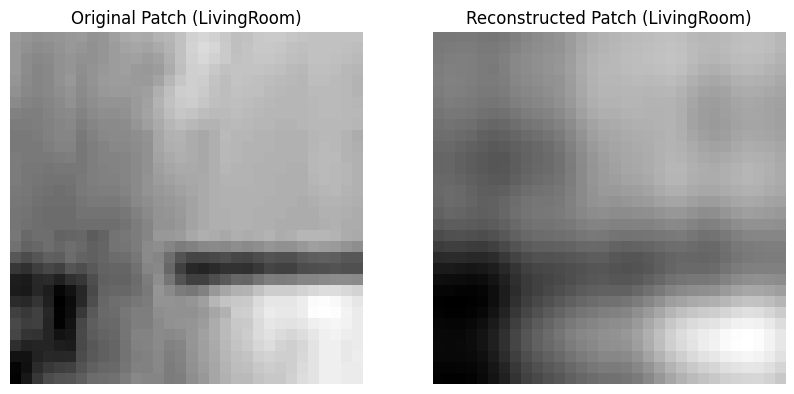

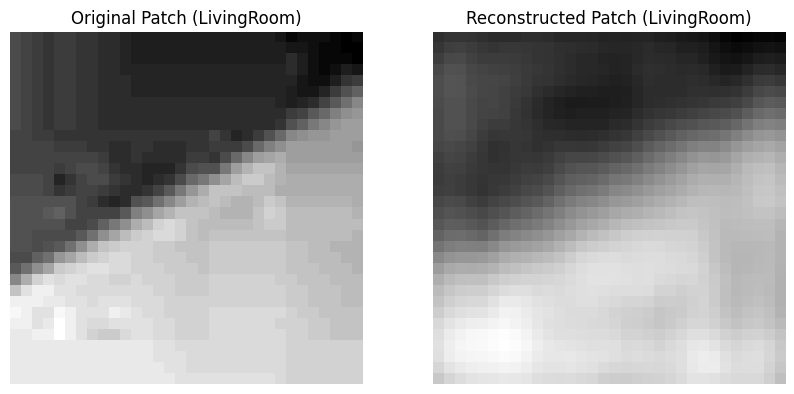

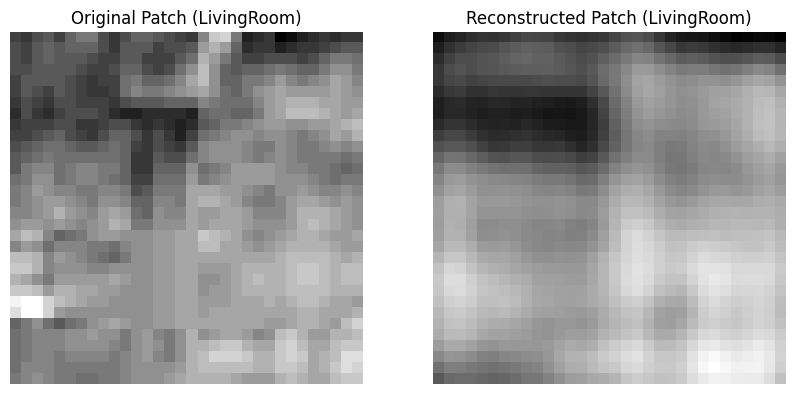

In [64]:
visualize_reconstructed_images(pca_by_category, training_patches_by_category)

In [65]:
test_patches_by_category = load_patches_by_category('patches_test', y, patch_size)

In [68]:
# Calcular OOD scores para os dados de teste
for test_category, test_patches in test_patches_by_category.items():
    ood_scores = {}
    for train_category in train_categories:
        # Normalizar e centralizar os dados de teste usando o scaler da categoria de treinamento
        normalized_centered_test_patches, _ = normalize_and_center_patches(test_patches, scalers_by_category[train_category])
        
        # Obter o PCA da categoria de treinamento
        pca = pca_by_category[train_category]
        
        # Calcular os resíduos
        residuals, reconstructed = compute_residuals_with_pca(normalized_centered_test_patches, pca)
        
        # Verificações de forma
        # print(f"Shape of normalized_centered_test_patches: {normalized_centered_test_patches.shape}")
        # print(f"Reconstructed = {reconstructed}")
        # print(f"Shape of residuals: {residuals.shape}")
        # print(f"Residuals = {residuals}")
        
        if normalized_centered_test_patches.shape != residuals.shape:
            raise ValueError("Shapes of normalized_centered_test_patches and residuals do not match.")
        
        # Calcular as medidas OOD
        scores = calculate_ood(normalized_centered_test_patches, residuals)
        ood_scores[train_category] = np.mean(scores)
    
    # Identificar a melhor categoria de treinamento (menor OOD score)
    best_environment = min(ood_scores, key=ood_scores.get)
    
    # Output formatado
    print(f"Test category: {test_category}")
    print(f"Best environment: {best_environment}")
    print(f"OOD scores: {ood_scores}")
    print()  # Linha em branco para separar as saídas

Test category: Bedroom
Best environment: LivingRoom
OOD scores: {'Bedroom': 0.2283230254897482, 'LivingRoom': 0.2192366000855572}

Test category: LivingRoom
Best environment: LivingRoom
OOD scores: {'Bedroom': 0.2469465938244269, 'LivingRoom': 0.23461335854163287}



In [67]:
for test_category, test_patches in test_patches_by_category.items():
    predictions = categorize_test_images(test_patches, pca_by_category, scalers_by_category)
    final_category = determine_final_category(predictions)
    print(f"Test category: {test_category}")
    print(f"Predictions: {predictions}")
    print(f"Final category: {final_category}")


Reconstruction error Bedroom = 0.22419105261415467
Reconstruction error LivingRoom = 0.21517399561850953
Test category: Bedroom
Predictions: ['LivingRoom']
Final category: LivingRoom
Reconstruction error Bedroom = 0.2379535924364478
Reconstruction error LivingRoom = 0.22473170965880745
Test category: LivingRoom
Predictions: ['LivingRoom']
Final category: LivingRoom
